In [2]:
import os
import sys

import cv2

import scipy
from scipy import ndimage as ndi
import numpy as np
import networkx as nx
import napari

from pathlib import Path
from tqdm.auto import tqdm

import ccdb
import astromorpho as astro
from ucats import masks as umasks

from argparser import create_parser
from networx2napari import draw_edges, draw_nodes


import numba as nb

Can't load imreg package, affine and homography registrations won't work


/home/anna/Documents/jupy_projects/funcut/image-funcut/imfun/external/tifffile.py:7261: UserWarning: No module named 'imfun.external._tifffile'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/home/anna/Documents/jupy_projects/funcut/image-funcut/imfun/external/czifile.py:146: UserWarning: ImportError: No module named '_czifile'. Decoding of JXR and JPEG encoded images will not be available. Czifile.pyx can be obtained at http://www.lfd.uci.edu/~gohlke/
  warnings.warn(


# Import files

In [3]:
from skeletonization import *
import ccdb

from skimage.morphology import remove_small_objects
from skimage.filters import threshold_li, threshold_minimum, threshold_triangle

In [4]:
import glob

files = '/home/anna/Documents/My_Astro/*.pic'


dataset = []
for f in glob.glob(files):
    dataset.append(f)


## Choose file

In [5]:
class PicAttr:
    def __init__(self, stack, meta, dims, name):
        self.stack = stack
        self.meta = meta
        self.dims = dims
        self.name = name

        
def PicFile(num):
    filename = dataset[num]
    stack, meta = ccdb.read_pic(filename)
    dims = ccdb.get_axes(meta)
    name = filename.replace('/home/anna/Documents/My_Astro/', '')
    file = PicAttr(stack, meta, dims, name)
    
    return file

In [6]:
Cell = PicFile(4)

In [7]:
stack = Cell.stack
dims = Cell.dims
name = Cell.name
meta = Cell.meta
print('Name:\t', name, '\n\nDims:\t', dims, '\n\nMeta:\t', meta)

Name:	 4wk-ly9-raw.pic 

Dims:	 [(0.06491228, "Microns'"), (0.06491228, "Microns'"), (0.2, "Microns'")] 

Meta:	 ["b'SCALE_FACTOR = 20.000000'", "b'LENS_MAGNIFICATION = 60.000000'", "b'PIXEL_BIT_DEPTH = 8'", "b'Z_CORRECT_FACTOR = 1.000000 3.081081'", "b'PIC_FF_VERSION = 4.3'", "b'RAMP1_MIN = 0'", "b'RAMP1_MAX = 255'", "b'RAMP_GAMMA1 = 1.000000e+000'", "b'AXIS_0 004 0.000000e+000 1.000000e+000 Intensity'", "b'AXIS_2 001 0.000000e+000 6.491228e-002 Microns'", "b'AXIS_3 001 0.000000e+000 6.491228e-002 Microns'", "b'AXIS_4 001 -4.800000e+000 2.000000e-001 Microns'", "b'AXIS_9 011 0.000000e+000 0.000000e+000 RGB chann'", "b'METHOD_NAME = grn'", "b'SETTINGS_COUNT = 1'", "b'SETTING_01_NAME = grn'", "b'SETTING_01_LASER_COUNT = 2'", "b'SETTING_01_LASER_01_NAME = Kr'", "b'SETTING_01_LASER_01_LINE_COUNT = 2'", "b'SETTING_01_LASER_01_LINE_01_COLOUR = 488'", "b'SETTING_01_LASER_01_LINE_01_POWER = 27.0'", "b'SETTING_01_DETECTOR_COUNT = 3'", "b'SETTING_01_DET_01_NAME = PMT1'", "b'SETTING_01_DET_01_IR

(-0.5, 1023.5, 1023.5, -0.5)

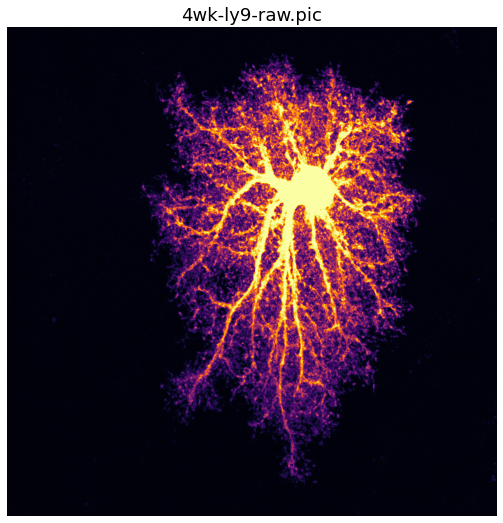

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (9, 9))
plt.imshow(stack.max(0), cmap = 'inferno')
plt.title(name, fontsize = 18)
plt.tight_layout
plt.axis('off')

# GET

## Masks

In [9]:
use_clahe = True

verbose = True
sigma = 2

# Set false to start from console
HANDY = True

# Set true to save output
OUT = False


In [10]:
if len(dims):
    zoom = (dims[-1][0]/dims[0][0])
else:
    zoom = 4
    
print(zoom)

3.081081114390066


### Preprocessing

#### CLAHE

In [11]:
import cv2
clahe = cv2.createCLAHE(clipLimit =2.0, tileGridSize=(8,8))

In [12]:
def CLAHE(stack):
    stack_shape = stack.shape
    img_clahe = np.zeros(stack.shape, np.float32)
    for k,plane in enumerate(stack):
        img_clahe[k] = clahe.apply(plane)

    img = img_clahe if use_clahe else stack
    return img

In [13]:
# #contrast
# wi = napari.view_image(stack, ndisplay = 3, scale = (zoom, 1, 1), colormap = 'inferno')
# wi.add_image(img_clahe, scale=(zoom,1,1), name='CLAHE',colormap='inferno')


In [14]:
# Кадрирование
def Framing(img):
    
    # Кадрирование 
    max_proj_xy = img.max(0)

    domain_mask_xy = ndi.binary_dilation(largest_region(remove_small_objects(max_proj_xy > 0.5*threshold_li(max_proj_xy))), iterations=3)
    domain_mask_xy = ndi.binary_closing(domain_mask_xy,iterations=3)
    img_cropped = np.array([crop_image(plane,domain_mask_xy, margin=10) for plane in img])

    max_proj_yz = img_cropped.max(1)
    domain_mask_yz = ndi.binary_dilation(largest_region(remove_small_objects(max_proj_yz > 0.5*threshold_li(max_proj_yz))), iterations=3)
    domain_mask_yz = ndi.binary_closing(domain_mask_yz,iterations=3)
    img_cropped = np.array([crop_image(img_cropped[:,i],domain_mask_yz, margin=10) for i in range(img_cropped.shape[1])]).swapaxes(0,1)
    
    ## Масштабирование
    downscale = 2
    img_noisy = ndi.zoom(img_cropped.astype(np.float32), (zoom/downscale, 1/downscale, 1/downscale), order=1)

    ## Фильтрация изображения
    img_clear = filter_image(img_noisy, threshold_li)
    final_image = img_clear
    
    return final_image


In [15]:
a = CLAHE(stack)
final_image = Framing(a)


In [16]:
def Soma_segmentation(final_image):
    ## Определение центра
    X1a = flat_indices(final_image.shape)
    weights_s = percentile_rescale(np.ravel(ndi.gaussian_filter(final_image,5))**2,plow=99.5,phigh=99.99)
    center = tuple(map(int, np.sum(X1a*weights_s[:,None],axis=0)/np.sum(weights_s)))

    ## Выделение сомы
    smooth_stack = ndi.gaussian_filter(final_image, 3)
    tol = (smooth_stack.max() - smooth_stack[final_image>0].min())/10
    soma_seed_mask = flood(smooth_stack, center, tolerance=tol)
    soma_mask = morpho.expand_mask(soma_seed_mask, smooth_stack, iterations = 10)
    soma_shell = get_shell_mask(soma_mask, as_points=True)
    
    Soma = {'Mask': soma_mask, 'Shell': soma_shell, 'Seed': soma_seed_mask}
    
    return Soma


In [17]:
Soma = Soma_segmentation(final_image)

In [18]:
soma_mask = Soma['Mask']
soma_shell = Soma['Shell']
soma_seed_mask = Soma['Seed']


In [19]:
# w = napari.view_image(final_image, ndisplay=3, opacity=0.5)
# w.add_image(soma_seed_mask, blending='additive', colormap='cyan')
# w.add_image(soma_mask, blending='additive', colormap='magenta')

In [20]:
# Расчет матрицы Гессе для различных сигм
sigmas = np.arange(0.5, 8, 0.5)
id2sigma = {i:sigma for i, sigma in enumerate(sigmas)}
sigma2id = {sigma:i for i, sigma in enumerate(sigmas)}


In [21]:
sato_coll = {}
Vf_coll = {}
vectors_coll = {}
# sato, Vf = astro.morpho.sato3d(final_image, sigma, hessian_variant='gradient_of_smoothed', do_brightness_correction=False, return_vectors=True)

def Calculate_sigma(final_image):
    for sigma in tqdm(sigmas, desc = 'sato_coll'):
        '''astro.morpho.sato3d is newer and uses tensorflow (if it's installed)
        #optimally, the two variants of sato3d should be merged'''
        sato, Vf = astro.morpho.sato3d(final_image, sigma, hessian_variant='gradient_of_smoothed', do_brightness_correction=False, return_vectors=True)
        sato_coll[sigma] = (sato*sigma**2)*(final_image > 0)
        Vf_coll[sigma] = Vf[...,0][...,::-1]

    lengths_coll = {sigma: astro.enh.percentile_rescale(sato)**0.5 for sigma, sato in sato_coll.items()}
    
    for sigma in tqdm(Vf_coll, desc = 'vectors_coll'):
        Vfx = Vf_coll[sigma]
        V = Vfx[..., 0]
        U = Vfx[..., 1]
        C = Vfx[..., 2]
        lengths = lengths_coll[sigma]
        vectors_coll[sigma] = np.stack((U*lengths, V*lengths, C*lengths), axis=3)
        

In [22]:
Calculate_sigma(final_image)

sato_coll:   0%|          | 0/15 [00:00<?, ?it/s]

2022-06-18 14:49:33.006588: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


vectors_coll:   0%|          | 0/15 [00:00<?, ?it/s]

In [24]:
# # Расчет масок для различных сигм
# sato = sato_coll[sigmas[1]]#*(final_image)
# threshold = threshold_li(sato[sato>0])
# mask = remove_small_objects(sato>threshold, int(sigma*64))
# masks = {}
# for sigma in tqdm(sigmas, desc = 'Calculating masks'):
#     sato = sato_coll[sigma]
#     threshold = threshold_li(sato[sato>0])*sigma**0.5
#     masks[sigma] = remove_small_objects(sato > threshold, min_size=int(sigma*64))
# masks[sigmas[-1]] = umasks.select_overlapping(masks[sigmas[-1]], soma_mask)
# for k in tqdm(range(len(sigmas)-2,-1,-1), desc = 'Setting attributes'):
#     sigma = sigmas[k]
#     masks[sigma] = umasks.select_overlapping(masks[sigma], ndi.binary_dilation(masks[sigmas[k+1]], iterations=5))

In [25]:
#Рассчет масок для различных сигм
sato = sato_coll[sigmas[1]]#*(final_image)
threshold = threshold_li(sato[sato>0])
mask = remove_small_objects(sato>threshold, int(sigma*64))
masks = {}

def Make_masks(sato_coll, sigmas):

    for sigma in tqdm(sigmas, desc = 'Calculating masks'):
        sato = sato_coll[sigma]
        threshold = threshold_li(sato[sato>0])*sigma**0.5
        masks[sigma] = remove_small_objects(sato > threshold, min_size=int(sigma*64))

    masks[sigmas[-1]] = umasks.select_overlapping(masks[sigmas[-1]], soma_mask)

    for k in tqdm(range(len(sigmas)-2,-1,-1), desc = 'Setting attributes to masks'):
        sigma = sigmas[k]
        masks[sigma] = umasks.select_overlapping(masks[sigma], ndi.binary_dilation(masks[sigmas[k+1]], iterations=5))

    # return masks

In [26]:
Make_masks(sato_coll, sigmas)

Calculating masks:   0%|          | 0/15 [00:00<?, ?it/s]

Setting attributes to masks:   0%|          | 0/14 [00:00<?, ?it/s]

In [27]:
# masks
np.unique(masks[sigma])

array([False,  True])

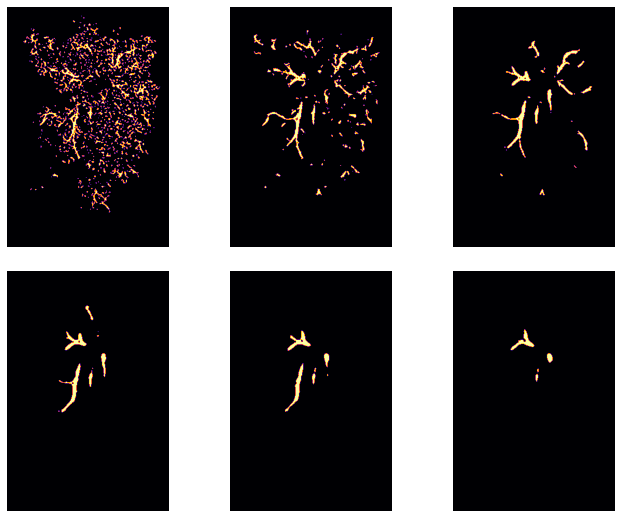

In [28]:
fig = plt.figure(figsize=(10, 10))
columns = 3
rows = 2
for i in range(1, columns*rows +1):
    img = masks[i][40, :, :]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap = 'inferno')
    plt.axis('off')
    
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=1, 
                    top=0.8, 
                    wspace=0.1, 
                    hspace=0.1)

plt.show()

In [29]:
import random
c = list(napari.utils.colormaps.AVAILABLE_COLORMAPS)
c = [*c[1:6], c[9], c[15], c[-1]]
choose_c = random.choice(c)

In [30]:
# w = napari.view_image(final_image,ndisplay=3)
         
# for sigma in sigmas:
#     sato = sato_coll[sigma]
#     choose_c = random.choice(c)
#     w.add_image(masks[sigma], blending='additive', name=f'σ={sigma:02f}', colormap = choose_c)

In [31]:
# Объединение собственных векторов различных сигм

vectors_best = np.zeros(vectors_coll[sigmas[0]].shape)
mask_sum = np.zeros(final_image.shape,bool)
masks_exclusive = {}


for k in range(len(sigmas)-1,-1,-1):
    sigma = sigmas[k]
    mask = masks[sigma]
    if k < len(sigmas)-1:
        mask = mask & (mask ^ mask_sum)
    mask_sum += mask.astype(bool)
    masks_exclusive[sigma] = mask
    vectors_best[mask] = vectors_coll[sigma][mask]

In [89]:
# def Vec_best(mask, final_image):
    
#     mask_sum = np.zeros(final_image.shape,bool)
    
#     for k in tqdm(range(len(sigmas)-1,-1,-1), desc = 'Calculating best vectors'):
#         sigma = sigmas[k]
#         mask = masks[sigma]
#         if k < len(sigmas)-1:
#             mask = mask & (mask ^ mask_sum)
            
#         mask_sum += mask.astype(bool)
#         masks_exclusive[sigma] = mask
#         vectors_best[mask] = vectors_coll[sigma][mask]
        

In [90]:

# w = napari.view_image(final_image, ndisplay = 3, opacity=0.5)
# colors = ['red', 'green', 'magenta', 'cyan', 'blue']
# for sigma, color in zip(masks, itt.cycle(colors)):
#     w.add_image(masks_exclusive[sigma], blending='additive', name=f'σ={sigma:02f}',colormap=color)
    
# w.add_image(soma_mask, name = 'Soma mask', blending='additive', colormap='magenta')

#### container

In [97]:
import h5py
import pickle
# import hdfdict

''' 
still need a function for dumping dictionary into a h5_file

hdfdic library didn't work for some reason
'''

save_path = '/home/anna/Documents/jupy_projects/Skeletonization/neuro.im-proc/Data_Files/'

def Save_h5(data, save_path, filename):
    
    NAME = os.path.join(save_path, str(filename)+'.h5')
    FILE = h5py.File(NAME, 'w')
    
    #datatype recognition
    is_it_dict = isinstance(data, dict)
    is_it_array = isinstance(data, np.ndarray)
    
    def Dict_debooled(data):
        debooled = {}

        for sigma in sigmas:
            debooling = masks_exclusive[sigma].astype('float')
            debooled[sigma] = debooling
        
    return debooled
    
    def Dict_dump():
        
        
    '''def List_reshaper:
        '''
        
    
    if is_it_dict == True:
        
        data_to_save = Dict_debooled(data)
        
        #####################################################
        # Some magic, which I hopefully will implement soon #
        #####################################################
        
        masks_data = FILE.create_dataset('Masks', data=data_to_save)

        
    elif is_it_array == True:
        
        masks_data = FILE.create_dataset('Masks', data = data)
        
            
    else:
        print('This datatype is not supporting (use dict or list)')
    

        # soma_ds = FILE.create_dataset('Soma_mask', data = soma_mask)
        # masks_ds = FILE.create_dataset('All_masks', data = masks)
        _mask = data_to_save.create_dataset(k.strftime('%Y-%m-%dT%H:%M:%SZ'), data=np.asarray(v, dtype=np.float64))
        
    
    FILE.close()
    
    

def Save_pickle(data, save_path, filename):
    
    NAME = os.path.join(save_path, str(name)+'.pickle')
    FILE = pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    


# COLLECT

## Single test

In [82]:
#get total mask in float version

total_recall = np.zeros_like(masks_exclusive[1], dtype=float)
for k in (masks_exclusive.keys()):
    total_recall[masks_exclusive[k]] = k

In [83]:
#rewrite dictionary with float values
debooled = {}

for sigma in sigmas:
    debooling = masks_exclusive[sigma].astype('float')
    debooled[sigma] = debooling

In [86]:
# w = napari.view_image(final_image, ndisplay=3)
# for sigma in sigmas:
#     choose_c = random.choice(c)
#     w.add_image(debooled[sigma], blending='additive', colormap=choose_c)

In [87]:
# w = napari.view_image(final_image, ndisplay=3)
# w.add_image(debooling_1, blending='additive', colormap='red')
# w.add_image(debooling_7, blending='additive', colormap='blue')


In [88]:
# np.flip(sigmas)

# SUMMARIZE 

In [57]:
# for pics in dataset:
    
    Cell = PicFile(i)
    
    stack = Cell.stack
    dims = Cell.dims
    name = Cell.name
    meta = Cell.meta
    
    #preparation 
    if len(dims):
        zoom = (dims[-1][0]/dims[0][0])
    else:
        zoom = 4
        
    final_image = Framing(CLAHE(stack))
    
    #Soma
    Soma = Soma_segmentation(final_image)
    
    soma_mask = Soma['Mask']
    soma_shell = Soma['Shell']
    soma_seed_mask = Soma['Seed']
    
    #Hesse + Sigmas
 
    sato_coll = {}
    Vf_coll = {}
    vectors_coll = {}
    
    Calculate_sigma(final_image)
    
    #Masks
    sato = sato_coll[sigmas[1]]#*(final_image)
    threshold = threshold_li(sato[sato>0])
    mask = remove_small_objects(sato>threshold, int(sigma*64))
    masks = {}
    
    Make_masks(sato_coll, sigmas)
    
    #Best vectors
    vectors_best = np.zeros(vectors_coll[sigmas[0]].shape)
    mask_sum = np.zeros(final_image.shape,bool)
    
    masks_exclusive = {}

    for k in range(len(sigmas)-1,-1,-1):
        sigma = sigmas[k]
        mask = masks[sigma]
        if k < len(sigmas)-1:
            mask = mask & (mask ^ mask_sum)
        mask_sum += mask.astype(bool)
        masks_exclusive[sigma] = mask
        vectors_best[mask] = vectors_coll[sigma][mask]



IndentationError: unexpected indent (2251289730.py, line 3)

# Graphs

In [ ]:
## Выражение для весов ребер
i, j, k = np.indices(final_image.shape)
idx = np.stack((i,j,k), axis=3)
crops_new = prep_crops()
crop,acrop = crops_new[1]

x1 = tensor_cosine_similarity(vectors_best[crop], vectors_best[acrop]);#, idx[crop], idx[acrop]);
W = calc_edges(vectors_best[crop], vectors_best[acrop], idx[crop], idx[acrop], alpha=0.5, return_W=True);

Wflat = W.ravel()
cond = Wflat < 1
Sx = 1-Wflat[cond]
thresholds = [1-threshold_minimum(Sx),
              1-threshold_li(Sx),
              1-threshold_triangle(Sx),
             ]
x3 = calc_edges(vectors_best[crop], vectors_best[acrop], idx[crop], idx[acrop], verbose=True);
x3l = list(x3)

alpha = 0.0
vectors = vectors_best
graph = nx.Graph()
for crop, acrop in tqdm(crops_new):
         graph.add_weighted_edges_from(calc_edges(vectors[crop], vectors[acrop], idx[crop], idx[acrop], alpha=alpha))

In [ ]:
## Добавление точек сомы в граф
Gsoma = nx.Graph()
soma_shell_mask = get_shell_mask(soma_mask)
for crop, acrop in tqdm(crops_new):
    Gsoma.add_weighted_edges_from(get_edges(soma_shell_mask, idx[crop], idx[acrop], 0.7))

for p1, p2, weight in Gsoma.edges(data=True):
    try:
        old_weight = graph.get_edge_data(p1, p2)['weight']
    except Exception as exc:
        old_weight = 1
        graph.add_edge(p1, p2, weight=min(weight['weight'], old_weight))
nodes = {n:n for n in graph.nodes()}


In [ ]:
def find_paths(G, targets, min_count=1, min_path_length=10):
    paths_dict = nx.multi_source_dijkstra_path(G, targets, )
    
    #reverse order of points in paths, so that they start at tips 
    paths_dict = {path[-1]:path[::-1] for path in paths_dict.values() if len(path) >= min_path_length}
    paths = list(paths_dict.values())
    points = count_points_paths(paths)

    qstack = np.zeros(vectors.shape[:-1])  #Это встречаемость точек в путях
    for p, val in points.items():
        if val >= min_count:
            qstack[p] = np.log(val)
    return qstack, paths_dict


def path_to_graph(path):
    "Converts an ordered list of points (path) into a directed graph"
    g = nx.DiGraph()
#     tp = path[0]
    root = tuple(path[-1])
    for k,p in enumerate(path):
        tp = tuple(p)
        g.add_node(tp, root=root) 
        if k > 0:
            g.add_edge(tp, tuple(path[k-1]), weight=1)
    return g
    
    
def view_graph(g, viewer, color=None, kind='points', name=None):
    if color is None:
        color = np.random.rand(3)
    pts = np.array(g.nodes)
    
    kw = dict(face_color=color, edge_color=color, blending='translucent_no_depth', name=name)
    if kind == 'points':
        viewer.add_points(pts, size=1, **kw)
    elif kind == 'path':
        viewer.add_shapes(pts, edge_width=0.5, shape_type='path', **kw)
        
    

def get_tips(g):
    return {n for n in g.nodes if len(list(g.successors(n))) == 0}
            
def get_roots(g):
    return {n for n in g.nodes if len(list(g.predecessors(n))) < 1}

def get_branch_points(g):
    return {n for n in gx.nodes if len(list(gx.successors(n))) > 1}          

In [ ]:
''' # Расчет путей, встречаемости точек в путях и слияние графов по путям

qstack_masks = {}
qstacks, paths_best = find_paths(graph, soma_shell)
all_tips = list(paths_best.keys())
domain_shell = get_shell_mask(masks_exclusive[np.min(sigmas)], do_skeletonize=True, as_points=True)
domain_shell = set(domain_shell)
tips = [t for t in tqdm(all_tips) if t in domain_shell]
tip_paths = [np.array(paths_best[t]) for t in tips]

graphs = []
for i, tp in tqdm(enumerate(tip_paths)):
    graphs.append(path_to_graph(tp))
    if i % 10000 == 0:
        gx_all = nx.compose_all(graphs)
        graphs = [gx_all]
gx_all = nx.compose_all(graphs) # УРА!!

# xpaths_all = graph_to_paths(gx_all)
# colored_paths_all = paths_to_colored_stack(xpaths_all, final_image.shape, change_color_at_branchpoints=False)

# w = napari.view_image(final_image, ndisplay=3, opacity=0.5)
# #props = {'path-id': ['line'+str(i) for i in np.arange(len(xpaths))]}
# w.add_image(colored_paths_all,  channel_axis=3, colormap=['red','green','blue'], name='cp_all')
# napari.run()
'''

In [ ]:
w = napari.view_image(final_image, ndisplay=3, opacity=0.5)
view_graph(Gsoma, w, kind='points', name='Points')
view_graph(Gsoma, w, kind = 'path', name = 'Path')

In [ ]:
np.array(Gsoma.nodes)

In [ ]:
np.array(Gsoma.edges)

In [ ]:
w = napari.view_image(final_image, ndisplay=3, opacity=0.5)
view_graph(graph, w, kind='points', name='Points')
view_graph(graph, w, kind = 'path', name = 'Path')



# Save graphs

## Save GML

In [ ]:
path = '/home/anna/Documents/jupy_projects/Skeletonization/neuro.im-proc/Data_Files'

def save_graph_gml(graph, path, name):
    name = name.replace('.pic', '')
    filename = Path(path).joinpath('graph_GML_'+name)
    nx.write_gml(graph, filename)

a = nx.Graph()
a.add_edges_from([(1, 2), (1, 3)])
a.add_node(1)
a.add_edge(1, 2)
a.add_node("spam")        # adds node "spam"
a.add_nodes_from("spam")  # adds 4 nodes: 's', 'p', 'a', 'm'
a.add_edge(3, 'm')
save_graph_gml(a, path, name)


In [ ]:
#     def save_celltype_graph(self, filename="celltype_conn.gml", format="gml"):
#         """
#         Save the celltype-to-celltype connectivity information in a file.
        
#         filename -- path of the file to be saved.

#         format -- format to save in. Using GML as GraphML support is
#         not complete in NetworkX.  

#         """
#         start = datetime.now()
#         if format == "gml":
#             nx.write_gml(self.__celltype_graph, filename)
#         elif format == "yaml":
#             nx.write_yaml(self.__celltype_graph, filename)
#         elif format == "graphml":
#             nx.write_graphml(self.__celltype_graph, filename)
#         elif format == "edgelist":
#             nx.write_edgelist(self.__celltype_graph, filename)
#         elif format == "pickle":
#             nx.write_gpickle(self.__celltype_graph, filename)
#         else:
#             raise Exception("Supported formats: gml, graphml, yaml. Received: %s" % (format))
#         end = datetime.now()
#         delta = end - start
#         config.BENCHMARK_LOGGER.info(
#             "Saved celltype_graph in file %s of format %s in %g s"
#             % (filename, format, delta.seconds + delta.microseconds * 1e-6)
#         )
#         print "Saved celltype connectivity graph in", filename

# Convert pickle to JSON


In [ ]:
import pickle
import json
import sys
import os

# # open pickle file
# def Picklson(file, path):
#     with open(sys.argv[1], 'rb') as infile:
#         obj = pickle.load(infile)

#     # convert pickle object to json object
#     json_obj = json.loads(json.dumps(obj, default=str))

#     # write the json file
#     with open(
#             os.path.splitext(sys.argv[1])[0] + '.json',
#             'w',
#             encoding='utf-8'
#         ) as outfile:
#         json.dump(json_obj, outfile, ensure_ascii=False, indent=4)

# Convert graphs to SWC

In [227]:
'''
Standardized swc files (www.neuromorpho.org)

  * An integer number as compartment identifier
  * Structure Identifier
  
0 - undefined
1 - soma
2 - axon
3 - (basal) dendrite
4 - apical dendrite
5+ - custom

  * x coordinate of the compartment
  * y coordinate of the compartment
  * z coordinate of the compartment
  * radius of the compartment
  * parent compartment

Special:
  * branch point (sometimes used for file parsing efficiency, branch 
    points are otherwise defined as points that have multiple children)
  * end point (leaf)
'''

'\nStandardized swc files (www.neuromorpho.org)\n\n  * an integer number as compartment identifier\n  * type of neuronal compartment\n  \n0 - undefined\n1 - soma\n2 - axon\n3 - (basal) dendrite\n4 - apical dendrite\n5+ - custom\n\n  * x coordinate of the compartment\n  * y coordinate of the compartment\n  * z coordinate of the compartment\n  * radius of the compartment\n  * parent compartment\n'